In [1]:
import numpy as np
import scanpy as sc
import anndata
import scvi
from scib_metrics.benchmark import Benchmarker
%matplotlib inline
import torch
from functions import *
import scib_metrics

/local/data/scvi-tools/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/local/data/scvi-tools/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/local/data/anaconda3/envs/BT/lib/python3.11/site-packages/numba/np/ufunc/dufunc.py:84: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  dispatcher = jit(_target='npyufunc',
/local/data/anaconda3/envs/BT/lib/python3.11/site-pac

In [2]:
adata = sc.read(
    "data/lung_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539942",
)

In [3]:
adata = sc.read(
    "data/Immune_ALL_human.h5ad"
)

In [4]:
adata

AnnData object with n_obs × n_vars = 33506 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

In [5]:
sc.pp.highly_variable_genes(adata, n_top_genes=8000, flavor="cell_ranger", batch_key="batch")
sc.tl.pca(adata, n_comps=30, use_highly_variable=True)

In [6]:
adata = adata[:, adata.var.highly_variable].copy()

In [7]:
adata.obsm["Unintegrated"] = adata.obsm["X_pca"]

In [8]:
%%capture
import scanorama

# List of adata per batch
batch_cats = adata.obs.batch.cat.categories
adata_list = [adata[adata.obs.batch == b].copy() for b in batch_cats]
scanorama.integrate_scanpy(adata_list)

adata.obsm["Scanorama"] = np.zeros((adata.shape[0], adata_list[0].obsm["X_scanorama"].shape[1]))
for i, b in enumerate(batch_cats):
    adata.obsm["Scanorama"][adata.obs.batch == b] = adata_list[i].obsm["X_scanorama"]

In [10]:
adata.X

<33506x8000 sparse matrix of type '<class 'numpy.float32'>'
	with 31478232 stored elements in Compressed Sparse Row format>

In [9]:
import pyliger

bdata = adata.copy()
# Pyliger normalizes by library size with a size factor of 1
# So here we give it the count data
bdata.X = bdata.layers["counts"]
# List of adata per batch
adata_list = [bdata[bdata.obs.batch == b].copy() for b in batch_cats]
for i, ad in enumerate(adata_list):
    ad.uns["sample_name"] = batch_cats[i]
    # Hack to make sure each method uses the same genes
    ad.uns["var_gene_idx"] = np.arange(bdata.n_vars)


liger_data = pyliger.create_liger(adata_list, remove_missing=False, make_sparse=False)
# Hack to make sure each method uses the same genes
liger_data.var_genes = bdata.var_names
pyliger.normalize(liger_data)
pyliger.scale_not_center(liger_data)
pyliger.optimize_ALS(liger_data, k=30)
pyliger.quantile_norm(liger_data)


adata.obsm["LIGER"] = np.zeros((adata.shape[0], liger_data.adata_list[0].obsm["H_norm"].shape[1]))
for i, b in enumerate(batch_cats):
    adata.obsm["LIGER"][adata.obs.batch == b] = liger_data.adata_list[i].obsm["H_norm"]

/local/data/anaconda3/envs/BT/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
/local/data/anaconda3/envs/BT/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
/local/data/anaconda3/envs/BT/lib/python3.11/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: Th

type: 'numpy.ndarray' object has no attribute 'power'

In [11]:
adata.write_h5ad(filename="data/adataImm.h5ad")

In [12]:
adata.write_h5ad(filename="data/adataw.h5ad")

KeyboardInterrupt: 

In [4]:
adata = anndata.read_h5ad(filename="data/adataw.h5ad")
adata

AnnData object with n_obs × n_vars = 32472 × 2000
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'pca'
    obsm: 'LIGER', 'Scanorama', 'Unintegrated', 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [13]:
adata = anndata.read_h5ad(filename="data/adataImm.h5ad")
adata

AnnData object with n_obs × n_vars = 33506 × 8000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'pca'
    obsm: 'Scanorama', 'Unintegrated', 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [14]:
sdnormalAdata, vaeSD = trainModelBenchmark(anndata.read_h5ad(filename="data/adataw.h5ad"), "sdnormal",max_epochs=200)

INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [06:22<00:00,  1.91s/it, v_num=1, train_loss_step=3.23e+3, train_loss_epoch=2.94e+3]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [06:22<00:00,  1.91s/it, v_num=1, train_loss_step=3.23e+3, train_loss_epoch=2.94e+3]


In [15]:
normalAdata, vaeN = trainModelBenchmark(anndata.read_h5ad(filename="data/adataw.h5ad"), "normal",max_epochs=200)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [06:02<00:00,  1.84s/it, v_num=1, train_loss_step=3.01e+3, train_loss_epoch=2.94e+3]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [06:02<00:00,  1.81s/it, v_num=1, train_loss_step=3.01e+3, train_loss_epoch=2.94e+3]


In [16]:
mogAdata, vaeMG = trainModelBenchmark(anndata.read_h5ad(filename="data/adataw.h5ad"), "mixofgaus",max_epochs=200)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [06:43<00:00,  2.07s/it, v_num=1, train_loss_step=3.18e+3, train_loss_epoch=2.94e+3]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [06:43<00:00,  2.02s/it, v_num=1, train_loss_step=3.18e+3, train_loss_epoch=2.94e+3]


In [17]:
vampAdata, vaeVP = trainModelBenchmark(anndata.read_h5ad(filename="data/adataw.h5ad"), "vamp",max_epochs=200)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/200:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 200/200: 100%|██████████| 200/200 [08:23<00:00,  2.54s/it, v_num=1, train_loss_step=2.79e+3, train_loss_epoch=2.94e+3]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [08:23<00:00,  2.52s/it, v_num=1, train_loss_step=2.79e+3, train_loss_epoch=2.94e+3]


Computing neighbors:   0%|          | 0/7 [00:00<?, ?it/s]/local/data/anaconda3/envs/BT/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/local/data/anaconda3/envs/BT/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/local/data/anaconda3/

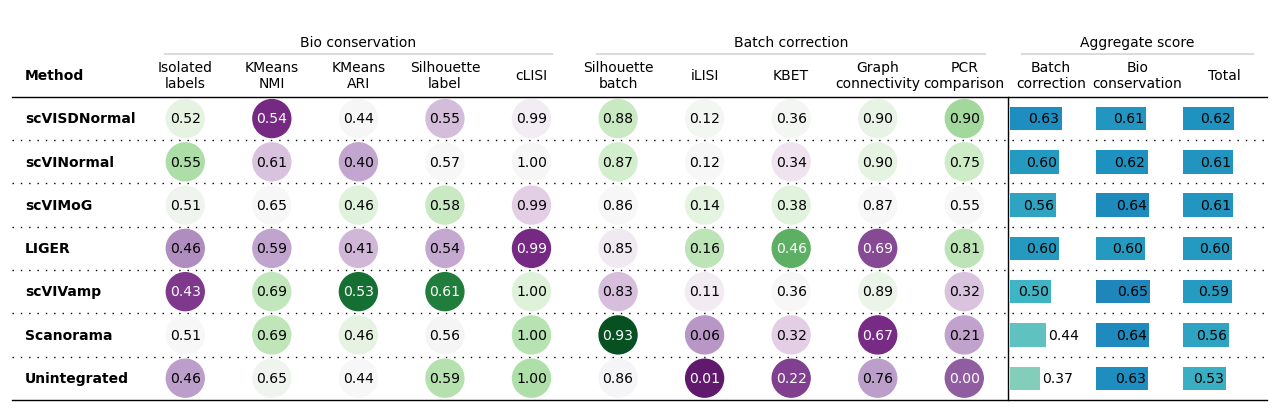

In [9]:
plotBenchmarkResultsAll(sdnormalAdata,normalAdata,mogAdata,vampAdata)

Embeddings:   0%|          | 0/7 [00:00<?, ?it/s]/local/data/anaconda3/envs/BT/lib/python3.11/site-packages/scib_metrics/_pcr_comparison.py:49: UserWarning: PCR comparison score is negative, meaning variance contribution increased after integration. Setting to 0.
  warnings.warn(
Embeddings: 100%|██████████| 7/7 [05:27<00:00, 46.76s/it]


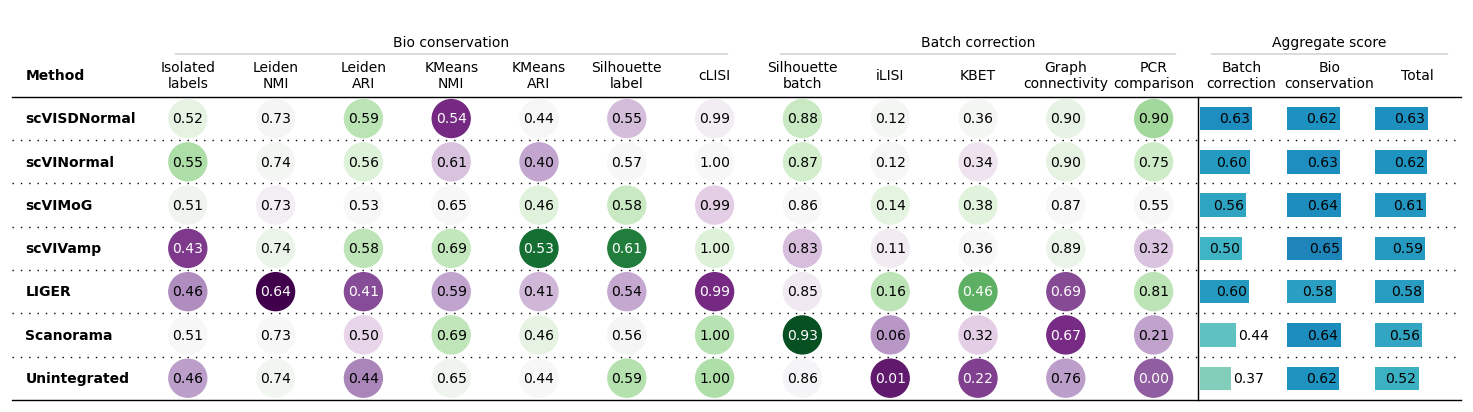

In [30]:
plotBenchmarkResultsAll(sdnormalAdata, normalAdata, mogAdata, vampAdata)

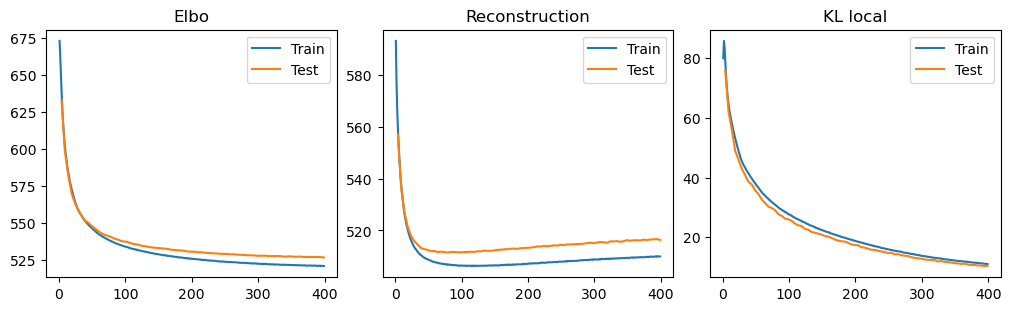

In [32]:
plotAllHistory(vaeSD)

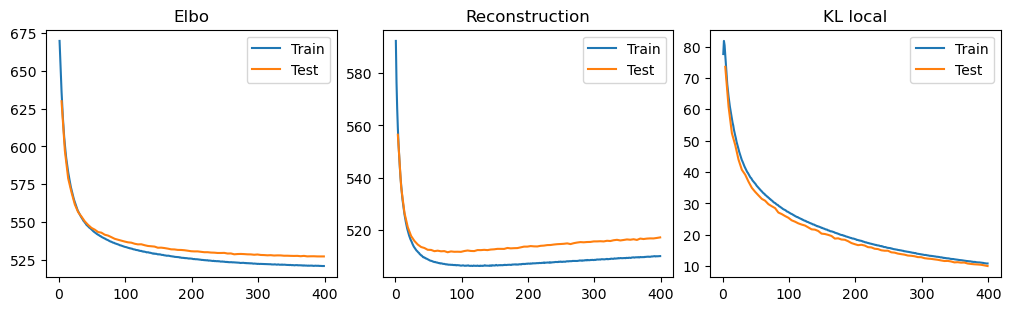

In [33]:
plotAllHistory(vaeN)

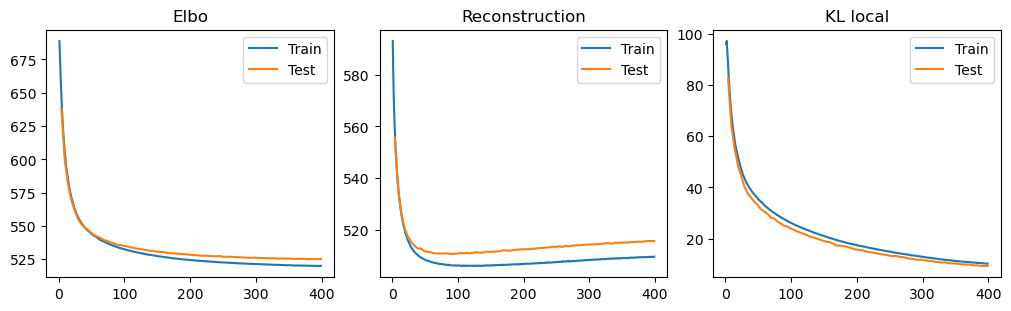

In [34]:
plotAllHistory(vaeMG)

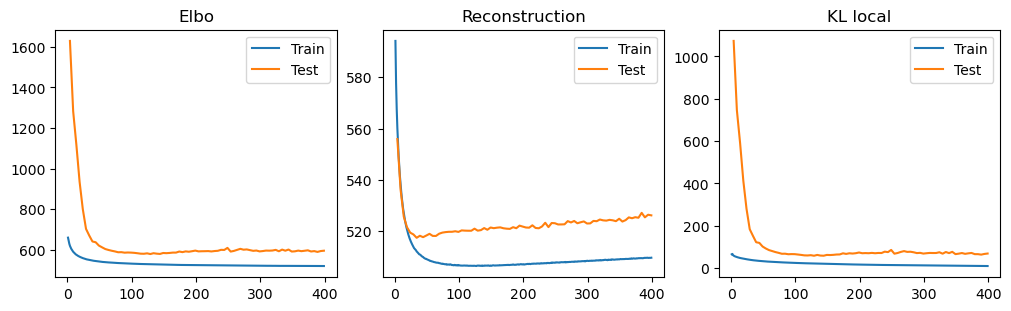

In [35]:
plotAllHistory(vaeVP)

In [27]:
def plotBenchmarkResults(adata,keys=None,label_key="cell_type"):
    if keys == None:
        keys = ["Unintegrated", "LIGER", "Scanorama", "scVI"]
    bm = Benchmarker(
    adata,
    batch_key="batch",
    label_key=label_key,
    embedding_obsm_keys=keys,
    bio_conservation_metrics=scib_metrics.benchmark.BioConservation(isolated_labels = True, nmi_ari_cluster_labels_leiden=True, nmi_ari_cluster_labels_kmeans = True, silhouette_label=True, clisi_knn = True),
    n_jobs=6,
    )
    bm.benchmark()
    bm.plot_results_table(min_max_scale=False)
    print("Hello")


In [35]:
adata

AnnData object with n_obs × n_vars = 33506 × 8000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'pca'
    obsm: 'Scanorama', 'Unintegrated', 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [34]:
plotBenchmarkResults(sdnormalAdata, ["Unintegrated","Scanorama", "scVI"],"final_annotation")

Embeddings:   0%|          | 0/3 [00:00<?, ?it/s]INFO:root:isolated labels: no more than 3 batches per label
INFO:root:CD10+ B cells: 0.41592130810022354
INFO:root:Erythrocytes: 0.6221303045749664
INFO:root:Erythroid progenitors: 0.5117929130792618
INFO:root:Monocyte progenitors: 0.43944382667541504
Embeddings:  33%|███▎      | 1/3 [00:41<01:22, 41.23s/it]INFO:root:isolated labels: no more than 3 batches per label
INFO:root:CD10+ B cells: 0.5615796819329262
INFO:root:Erythrocytes: 0.6190832182765007
INFO:root:Erythroid progenitors: 0.618623897433281
INFO:root:Monocyte progenitors: 0.5377684235572815
Embeddings:  67%|██████▋   | 2/3 [07:30<04:18, 258.00s/it]INFO:root:isolated labels: no more than 3 batches per label
INFO:root:CD10+ B cells: 0.6114084497094154
INFO:root:Erythrocytes: 0.5644783601164818
INFO:root:Erythroid progenitors: 0.5961045324802399
INFO:root:Monocyte progenitors: 0.5493930131196976
Embeddings: 100%|██████████| 3/3 [08:10<00:00, 163.34s/it]


Hello


In [26]:
plotBenchmarkResults(normalAdata, ["Unintegrated","Scanorama", "scVI"],"final_annotation")

Embeddings:   0%|          | 0/3 [00:00<?, ?it/s]INFO:root:isolated labels: no more than 3 batches per label
INFO:root:CD10+ B cells: 0.41592130810022354
INFO:root:Erythrocytes: 0.6221303045749664
INFO:root:Erythroid progenitors: 0.5117929130792618
INFO:root:Monocyte progenitors: 0.43944382667541504
Embeddings:  33%|███▎      | 1/3 [00:36<01:13, 36.78s/it]INFO:root:isolated labels: no more than 3 batches per label
INFO:root:CD10+ B cells: 0.5615796819329262
Embeddings:  33%|███▎      | 1/3 [02:28<04:57, 148.93s/it]


KeyboardInterrupt: 

In [ ]:
plotBenchmarkResults(mogAdata, ["Unintegrated","Scanorama", "scVI"],"final_annotation")

In [ ]:
plotBenchmarkResults(vampAdata, ["Unintegrated","Scanorama", "scVI"],"final_annotation")